In [2]:
# 04_train_Triplet Siamese_1.ipynb
# Step 1: 导入必要库

import os, random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm


In [4]:
# Step 2: Triplet 数据集构建

class TripletSignatureDataset(Dataset):
    """
    生成 Triplet (anchor, positive, negative)
    - anchor 与 positive 为同一人 genuine 图像
    - anchor 与 negative 为不同人 forged 图像
    """
    def __init__(self, root_dir, user_ids, transform=None):
        self.root_dir = Path(root_dir)
        self.user_ids = user_ids
        self.transform = transform
        self.triplets = self._generate_triplets()

    def _generate_triplets(self):
        triplets = []
        for user in self.user_ids:
            user_path = self.root_dir / user
            genuine_imgs = sorted(user_path.glob("original_*.png"))
            forged_imgs = sorted(user_path.glob("forgeries_*.png"))
            if len(genuine_imgs) < 2:
                continue
            for _ in range(50): # 每人生成若干 triplet
                anchor, positive = random.sample(genuine_imgs, 2)
                # 随机选一个 negative 来自其他人的 forged 图像
                neg_user = random.choice([u for u in self.user_ids if u != user])
                neg_path = self.root_dir / neg_user
                neg_candidates = list(neg_path.glob("forgeries_*.png"))
                if not neg_candidates:
                    continue
                negative = random.choice(neg_candidates)
                triplets.append((str(anchor), str(positive), str(negative)))
        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a_path, p_path, n_path = self.triplets[idx]
        a = Image.open(a_path).convert("L")
        p = Image.open(p_path).convert("L")
        n = Image.open(n_path).convert("L")
        if self.transform:
            a = self.transform(a)
            p = self.transform(p)
            n = self.transform(n)
        return a, p, n


In [6]:
# Step 3: DeeperCNN 特征提取网络

class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.features(x)


In [16]:
# Step 4: 数据加载与配置

project_root = Path("E:/MyProject/signature_project")
exp_path = project_root / "experiments" / "Triplet_E1(personsplit)"
exp_path.mkdir(parents=True, exist_ok=True)
data_root = project_root / "processed_data"

user_dirs = sorted([d.name for d in data_root.iterdir() if (data_root / d).is_dir()])
random.seed(42)

# 自动读取所有合法的用户名（如 "1", "2", ..., "55"），只保留图像充足者
train_users = []
val_users = []
test_users = []

user_ids = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
user_ids = [uid for uid in user_ids if uid.isnumeric()]  # 只保留纯数字的用户名

user_ids = sorted(user_ids, key=lambda x: int(x))  # 按数字排序

# 分割 0~43 为训练，44~49 为验证，50~55 为测试
train_users = user_ids[0:44]
val_users   = user_ids[44:50]
test_users  = user_ids[50:56]

print("✅ 用户划分完成")
print("Train:", train_users)
print("Val:", val_users)
print("Test:", test_users)


train_transform = transforms.Compose([
    transforms.Resize((155, 220)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((155, 220)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((155, 220)),
    transforms.ToTensor()
])

train_dataset = TripletSignatureDataset(data_root, train_users, transform=train_transform)
val_dataset   = TripletSignatureDataset(data_root, val_users, transform=val_transform)
test_dataset = TripletSignatureDataset(data_root, test_users, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)


✅ 用户划分完成
Train: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44']
Val: ['45', '46', '47', '48', '49', '50']
Test: ['51', '52', '53', '54', '55']


In [18]:
# Step 5: 模型训练（Triplet Loss）

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperCNN().to(device)
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
patience = 5
best_val_loss = float("inf")
trigger_times = 0

log_path = exp_path / "metrics.csv"
model_path = exp_path / "best_model.pth"
train_logs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for a, p, n in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        a, p, n = a.to(device), p.to(device), n.to(device)
        out_a, out_p, out_n = model(a), model(p), model(n)
        loss = criterion(out_a, out_p, out_n)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for a, p, n in val_loader:
            a, p, n = a.to(device), p.to(device), n.to(device)
            out_a, out_p, out_n = model(a), model(p), model(n)
            loss = criterion(out_a, out_p, out_n)
            val_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")
    train_logs.append({"epoch": epoch+1, "train_loss": total_loss, "val_loss": val_loss})

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), model_path)
        print(f"✅ 最佳模型已保存至 {model_path}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(" Early stopping activated.")
            break

pd.DataFrame(train_logs).to_csv(log_path, index=False)


Epoch 1 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [08:09<00:00,  3.55s/it]


Epoch 1 | Train Loss: 28.1758 | Val Loss: 2.8054
✅ 最佳模型已保存至 E:\MyProject\signature_project\experiments\Triplet_E1(personsplit)\best_model.pth


Epoch 2 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [08:08<00:00,  3.54s/it]


Epoch 2 | Train Loss: 14.1913 | Val Loss: 2.5845
✅ 最佳模型已保存至 E:\MyProject\signature_project\experiments\Triplet_E1(personsplit)\best_model.pth


Epoch 3 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [08:02<00:00,  3.49s/it]


Epoch 3 | Train Loss: 12.1034 | Val Loss: 1.4293
✅ 最佳模型已保存至 E:\MyProject\signature_project\experiments\Triplet_E1(personsplit)\best_model.pth


Epoch 4 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [08:33<00:00,  3.72s/it]


Epoch 4 | Train Loss: 10.6615 | Val Loss: 2.5761


Epoch 5 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [07:51<00:00,  3.42s/it]


Epoch 5 | Train Loss: 8.3940 | Val Loss: 1.8418


Epoch 6 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [07:50<00:00,  3.41s/it]


Epoch 6 | Train Loss: 8.7419 | Val Loss: 2.0667


Epoch 7 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [09:07<00:00,  3.97s/it]


Epoch 7 | Train Loss: 7.5685 | Val Loss: 1.9059


Epoch 8 [Train]: 100%|███████████████████████████████████████████████████████████████| 138/138 [08:43<00:00,  3.79s/it]


Epoch 8 | Train Loss: 6.6575 | Val Loss: 1.5508
 Early stopping activated.


评估使用的用户数: 5
Triplet 样本总数: 250


Evaluating...: 100%|███████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


测试集准确率: 0.9580
测试集F1分数: 0.9567
              precision    recall  f1-score   support

           0     0.9321    0.9880    0.9592       250
           1     0.9872    0.9280    0.9567       250

    accuracy                         0.9580       500
   macro avg     0.9597    0.9580    0.9580       500
weighted avg     0.9597    0.9580    0.9580       500



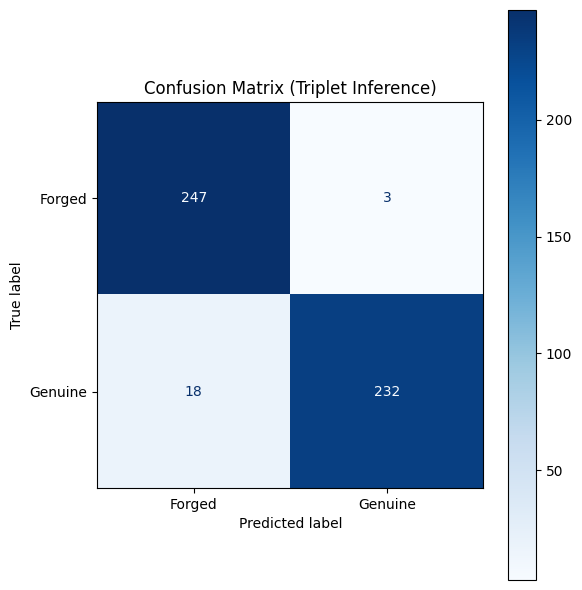

In [30]:
# Step 6：模型评估（基于欧氏距离 + 阈值判断真假）

print(f"评估使用的用户数: {len(test_users)}")
print(f"Triplet 样本总数: {len(test_dataset)}")

from scipy.spatial.distance import euclidean

# 加载最佳模型
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 使用测试集进行真伪判断测试（Anchor vs Positive → True，Anchor vs Negative → False）
all_labels, all_scores, all_preds = [], [], []

with torch.no_grad():
    for a, p, n in tqdm(test_loader, desc="Evaluating..."):
        a, p, n = a.to(device), p.to(device), n.to(device)

        f_a = model(a)
        f_p = model(p)
        f_n = model(n)

        for i in range(f_a.shape[0]):
            d_pos = euclidean(f_a[i].cpu().numpy(), f_p[i].cpu().numpy())
            d_neg = euclidean(f_a[i].cpu().numpy(), f_n[i].cpu().numpy())
            all_scores.append((d_pos, d_neg))
            all_labels += [1, 0]

# 设定阈值
threshold = 2.480
all_preds = []

for d_pos, d_neg in all_scores:
    all_preds += [int(d_pos < threshold), int(d_neg < threshold)]

# 计算指标
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f"测试集准确率: {acc:.4f}")
print(f"测试集F1分数: {f1:.4f}")

# 分类报告与混淆矩阵
report = classification_report(all_labels, all_preds, digits=4)
print(report)

report_path = exp_path / "classification_report.txt"
with open(report_path, "w") as f:
    f.write(report)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Forged", "Genuine"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix (Triplet Inference)")
plt.grid(False)
plt.tight_layout()
plt.savefig(exp_path / "confusion_matrix.png")
plt.show()


In [22]:
# Step 7.1：收集所有欧氏距离
from scipy.spatial.distance import euclidean

all_labels, dists, pairs = [], [], []

model.eval()
with torch.no_grad():
    for a, p, n in tqdm(test_loader, desc="Collecting distances..."):
        a, p, n = a.to(device), p.to(device), n.to(device)
        f_a = model(a)
        f_p = model(p)
        f_n = model(n)
        for i in range(len(f_a)):
            dists.append(euclidean(f_a[i].cpu().numpy(), f_p[i].cpu().numpy()))
            all_labels.append(1)
            dists.append(euclidean(f_a[i].cpu().numpy(), f_n[i].cpu().numpy()))
            all_labels.append(0)


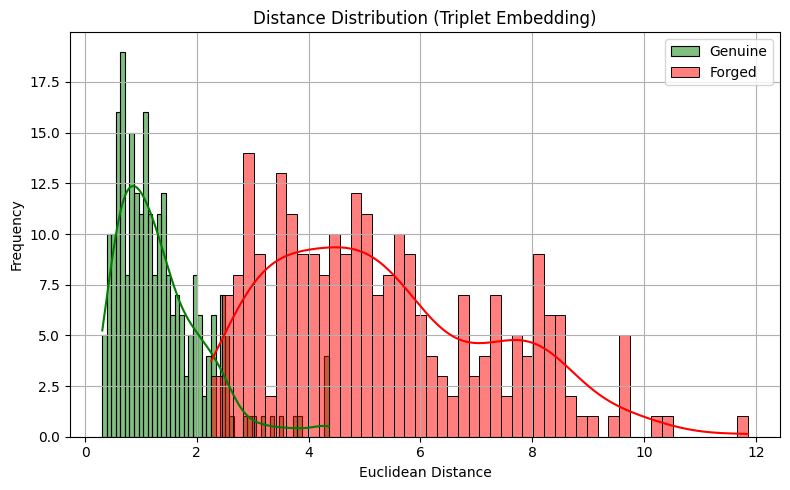

In [24]:
# Step 7.2：绘制 Genuine vs Forged 的距离分布图
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot([d for i, d in enumerate(dists) if all_labels[i]==1], label='Genuine', color='green', bins=50, kde=True)
sns.histplot([d for i, d in enumerate(dists) if all_labels[i]==0], label='Forged', color='red', bins=50, kde=True)
plt.title("Distance Distribution (Triplet Embedding)")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Step 7.3：网格搜索最佳 threshold
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

best_acc, best_f1, best_t = 0, 0, 0
thresholds = np.linspace(0.5, 2.5, 100)
acc_list, f1_list = [], []

for t in thresholds:
    preds = [int(d < t) for d in dists]
    acc = accuracy_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    acc_list.append(acc)
    f1_list.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        best_t = t

print(f"📌 最佳阈值: {best_t:.3f} | Accuracy: {best_acc:.4f} | F1: {best_f1:.4f}")


📌 最佳阈值: 2.480 | Accuracy: 0.9580 | F1: 0.9567


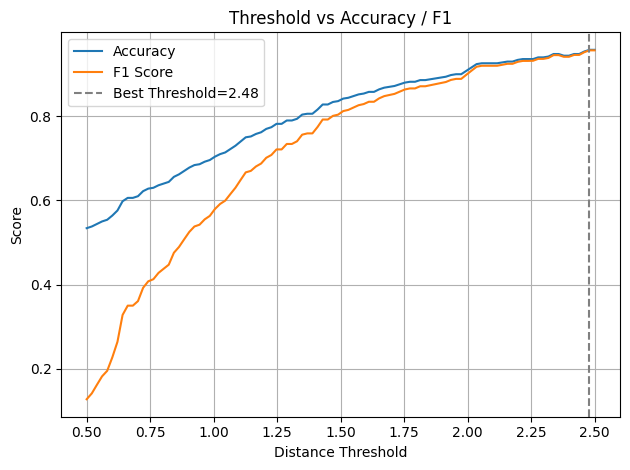

In [28]:
# Step 7.4：绘制性能曲线
plt.plot(thresholds, acc_list, label="Accuracy")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.axvline(best_t, linestyle="--", color="gray", label=f"Best Threshold={best_t:.2f}")
plt.xlabel("Distance Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Accuracy / F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
